# Анализ рынка видеоигр
Выявление определяющих успешность закономерностей видеоигр для фиксирования ставки на потенциально популярный продукт и планирования рекламных кампаний.

#### Оглавление: 
<a class="anchor" id="step_0"></a>  

* [1. Загрузка файлов с данными и изучение общей информации.](#step_1)
* [2. Подготовка данных](#step_2) 
* [3. Исследовательский анализ данных](#step_3)
 * [3.1. Сколько игр выпускалось в разные годы и определение актуального периода](#step_3.1) 
 * [3.2. Как менялись продажи по платформам ](#step_3.2) 
 * [3.3. Определение актуального периода](#step_3.3)
 * [3.4. Выбор потенциально прибыльных платформ](#step_3.4) 
 * [3.5. Влияние на продажи отзывов пользователей и критиков](#step_3.5)
 * [3.6. Анализ распределения игр по жанрам](#step_3.6)
* [4. Портрет пользователя каждого региона](#step_4)
* [5. Проверка гипотез](#step_5)
* [6. Общий вывод](#step_6)


### 1. Загрузка файлов с данными и изучение общей информации.  
[к оглавлению](#step_0)
<a class="anchor" id="step_1"></a>

In [1]:
import pandas as pd # Импортируем необходимые библиотеки
import numpy as np
from IPython.core.display import display
from scipy import stats as st
from math import sqrt, ceil

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

import warnings # отключим предупреждения анаконды
warnings.filterwarnings('ignore')
# sns.set() # Стилизуем графики
plt.rcParams['figure.figsize']=(18,6) # Зададим размер графиков по умолчанию
pd.set_option('max_columns', None) # Зададим вывод всех столбцов таблиц
pd.options.display.float_format = '{:.2f}'.format # Зададим удобный формат отображения вещественных чисел

In [2]:
# Функция если понадобится получить имя фрейма или серии
def get_name(obj):
    name =[x for x in globals() if globals()[x] is obj][0]
    return name

In [3]:
df = pd.read_csv('/Users/victorchudnovskiy/Documents/raw_csv/games.csv')
display(df.head())
display(df.info())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

In [4]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [5]:
print(f'выявлено {df.duplicated().sum()} дубликатов')

выявлено 0 дубликатов


### Вывод
Данные представлены одним набором, состоящим из 11 столбцов и 16715 строк. Были обнаружены пропуски в:
- Наименовании игры и платформы;
- Годах релизов;
- Оценках экспертов и пользователей;
- Рейтинге ESRB.  

Первые три позиции определенно связаны с ошибками в при выгрузе данных, а последние с простым отсутвием отзывов или рейтингов.  
Дубликатов при загрузке датасета выявлено не было.

### 2. Предобработка данных.     
[к оглавлению](#step_0)
<a class="anchor" id="step_2"></a>


Обратим внимание на то, что названия столбцов начинаются с заглавной буквы. Исправим это неоразумение и приведем назавания в нижний регистр

In [6]:
# Для переименования столбцов в нижний регистр вытащим назавания в отдельный список и применив list comprehension соберем вновь
# но уже из прописных букв используя строчный метод lower
df.columns = [i.lower() for i in df.columns.to_list()]
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.00,Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,1985.00,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.00,Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,2009.00,Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.00,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Поскольку пропусков в имени, жанре и годах релизов не так много и их никак не восстановить, без сожаления удалим эти строки. К тому же от данных без этой информации нам профиту никакого.

In [7]:
df.dropna(subset = ['name', 'genre', 'year_of_release'], inplace = True) 

Оценки пользователй представлены типом `object` это значит что помимо числел в данных есть и строки. Проверим из каких значений стостоит этот столбец.

In [8]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Оказывается среди оценок присутствует значение **tbd**. Это аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей. Иными словами, это **ПРОПУСКИ**

In [9]:
df['user_score'].replace('tbd', np.nan, inplace=True)

Приведем наши данные к соответсвующим типам, а именно:  
- Годы релиза к целым числам
- Пользовательские оценки к вещественным числам

In [10]:
df = df.astype({'user_score': 'float',
     'year_of_release': 'int'})

Добавим столбец с мировыми продажами как сумму всех продаж по регионам

In [11]:
df['ww_sales'] = df.iloc[:, 4:8].sum(axis=1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,ww_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


Данные приобрели ожидаемый вид. В завершении выведем обновленную информацию о наборе данных

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
 11  ww_sales         16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


### Вывод
Все несущественные отсутсвующие значения в данных о названии продукта, его жанре и годе выпуска были удалены. Данные о рейтингах не подлежат заполнению, поскольку заполнить можно то что утеряно, а этих данных просто не было, следовательно оставим пропуски как есть.

### 3. Исследовательский анализ данных.   
[к оглавлению](#step_0)
<a class="anchor" id="step_3"></a>

#### 3.1 Сколько игр выпускалось в разные годы и определение актуального периода   
[к оглавлению](#step_0)
<a class="anchor" id="step_3.1"></a>

Для ответа на этот вопрос построим столбиковую диаграмму, где по шкале абсцисс отметим годы, а по шкале ординат количество выпущенных игр.

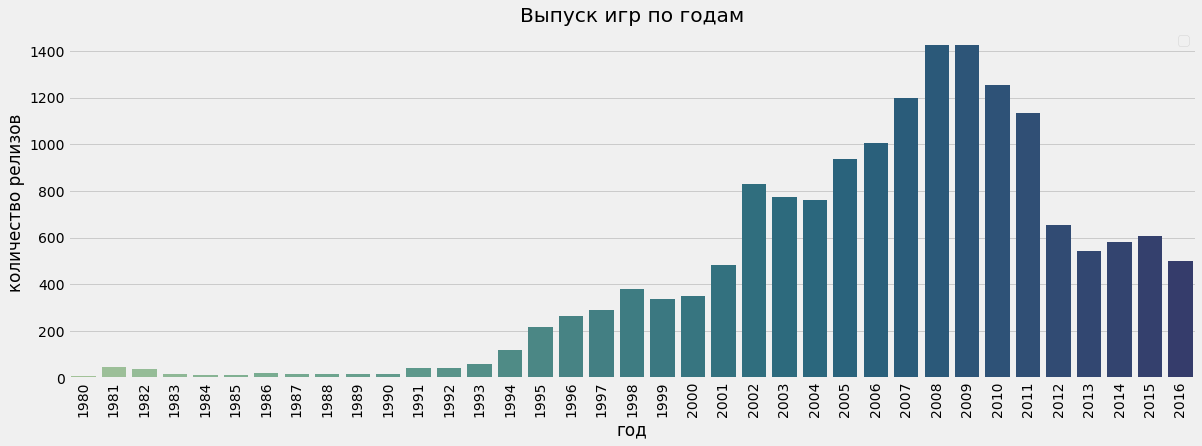

In [13]:
# Создадим сводную таблицу по годам суммируя количество наименований
releases_by_year = df.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()
# На основе созданной сводной тиблицы создадим столбиковую диаграмму из библиотеки seaborn
sns.barplot(x='year_of_release', y='name', data=releases_by_year, palette='crest')
# Зададим необходимые параметры для графика
plt.legend('')
plt.title('Выпуск игр по годам')
plt.xlabel('год')
plt.ylabel('количество релизов')
plt.xticks(rotation=90)
plt.show()

Как видно на графике, видеоигры эволюционировали волнами.  
- До 1994 игр выпускалось очень мало. Представлены они были скорее всего примитивными образцами вроде "Тетриса" или предназначены для узкого круга пользователей.
- Следующий период с 1995 по 2000. Эпоха доткомов и великолепных рейвов способствовали интересу общества к киберкультуре и видеоиграм, как ее части.
- С 2001 по 2008. Бурному росту индрустрии видеоигр способствовали благоденствие в мировой экономике, уже сильно развившийся интернет и доступность консолей.
- С 2009 по 2012. Спад выпуска после ипотечного кризиса в США 2008г. и как следствие кризиса в мировой экономике.
- С 2013 по Н/В. Относительно ровный период. Выпуск порядка 500-600 игр в год. **Это период (без 2016, так как он еще не окончен) мы и примем в качестве актуального**.

#### 3.2 Как менялись продажи по платформам   [к оглавлению](#step_0)
<a class="anchor" id="step_3.2"></a>

Выведем список 15 самых результативных платформ за всю историю человечества

In [14]:
top_n = 15
top_platform_list = (
    df.pivot_table(index='platform', values='ww_sales', aggfunc='sum').
    reset_index().sort_values(by = 'ww_sales', ascending = False).
    head(top_n)['platform'].
    to_list()
)
print(*top_platform_list)

PS2 X360 PS3 Wii DS PS PS4 GBA PSP 3DS PC GB XB NES N64


Чтобы оценить как менялись продажи по платформам построим распределение по годам в виде тепловой карты, которая позволит в двух плоскостях изучить трехмерные данные (название платформы, год релиза, количество проданных копий). Таким образом мы сможем выявить характерный срок, за который появляются новые и исчезают старые платформы, не потеряв данные об объемах продаж?

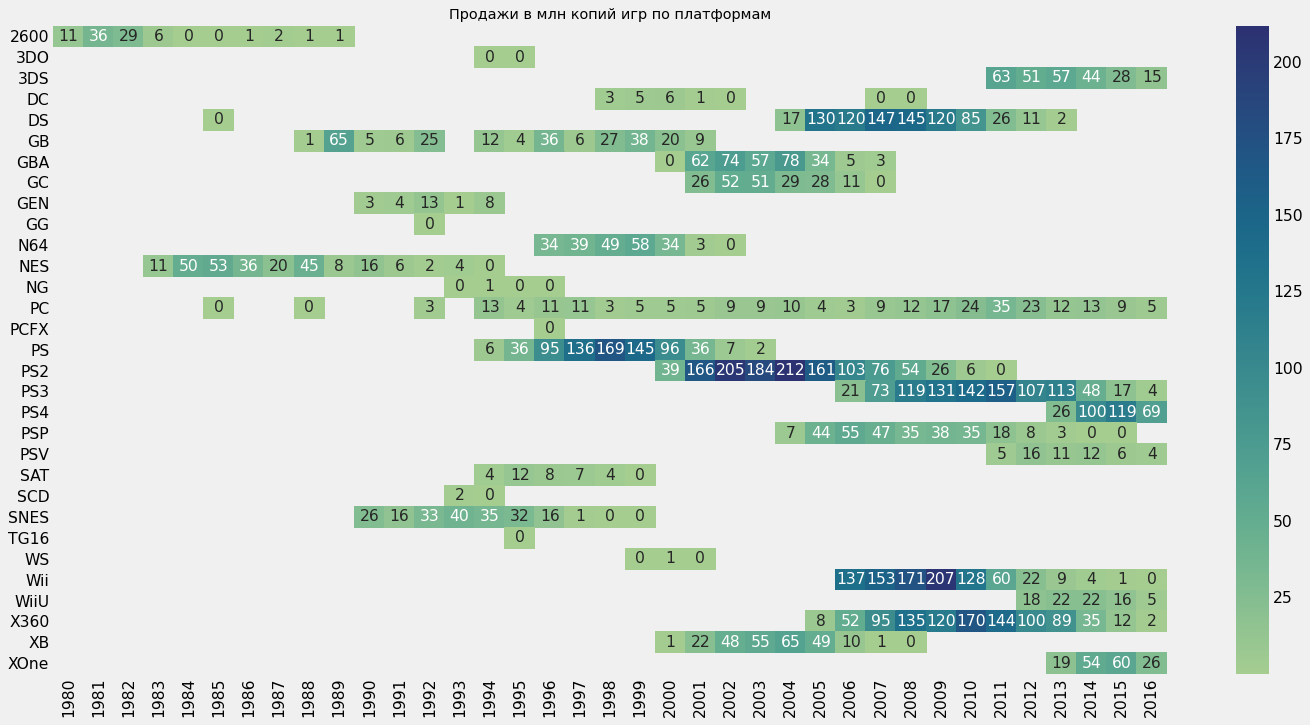

In [15]:
sales = df.pivot_table(index='platform', columns='year_of_release', values='ww_sales', aggfunc='sum')
plt.figure(figsize=(20,10), dpi= 80)
sns.heatmap(sales, annot=True, fmt='.0f', cmap= 'crest', cbar=True)
plt.title('Продажи в млн копий игр по платформам', fontsize=13)
plt.xlabel('')
plt.ylabel('')
plt.show()

Дополним график таблицами и расчетами периода жизни платформ

In [16]:
platform_life = df.sort_values(by = 'year_of_release').pivot_table(index='platform', values='year_of_release', aggfunc=['first', 'last'])
platform_life.columns = ['rise', 'down']
platform_life['long_life'] = platform_life['down'] - platform_life['rise']
platform_life.reset_index().sort_values(by='long_life', ascending=False).sample(10)

,platform,rise,down,long_life
11,NES,1983,1994,11
17,PS3,2006,2016,10
28,X360,2005,2016,11
24,TG16,1995,1995,0
26,Wii,2006,2016,10
20,PSV,2011,2016,5
29,XB,2000,2008,8
21,SAT,1994,1999,5
8,GEN,1990,1994,4
22,SCD,1993,1994,1


In [17]:
a = platform_life.reset_index()['long_life'].describe()['50%']
print(f'Медианный период жизни платформ {int(a)} лет')

Медианный период жизни платформ 6 лет


И тепловая карта и расчеты говорят о том что не все выживают в мире видеоигр. Есть и старожилы в виде PC, платформа которая будет востребованна пока есть компьютеры и фрики-однодневки типа GG. Характерный период жизни платформы 6 лет.  
Можно отметить что Wii повторяет судьбу PS2 - бурный рост с продажами за 200 млн копий и постепенный спад.  
PS4 сейчас на подъеме. Замечу, 2016 год еще не окончен.

#### 3.3 Определение актуального периода  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.3"></a>
Принцип определения актуального периода был подробно описан в пункте 3.1  
Для дальнейшего анализа, целью которого является прогноз деятельности на 2017г. выберем период с 2014г. по 2015г. т.к. это относительно стабильный период, 2013 год переходный, а данные за 2016 могут быть неполными.

In [18]:
actual_df = df.query('2013 < year_of_release < 2016')
actual_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1187 entries, 31 to 16707
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1187 non-null   object 
 1   platform         1187 non-null   object 
 2   year_of_release  1187 non-null   int64  
 3   genre            1187 non-null   object 
 4   na_sales         1187 non-null   float64
 5   eu_sales         1187 non-null   float64
 6   jp_sales         1187 non-null   float64
 7   other_sales      1187 non-null   float64
 8   critic_score     486 non-null    float64
 9   user_score       626 non-null    float64
 10  rating           660 non-null    object 
 11  ww_sales         1187 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 120.6+ KB


#### 3.4 Выбор потенциально прибыльных платформ.   
[к оглавлению](#step_0)
<a class="anchor" id="step_3.4"></a>


Посторим диаграмму объмов продаж по платформам и годам актуального периода (в дальнейшем все расчеты относятся к периоду 2014-2015)

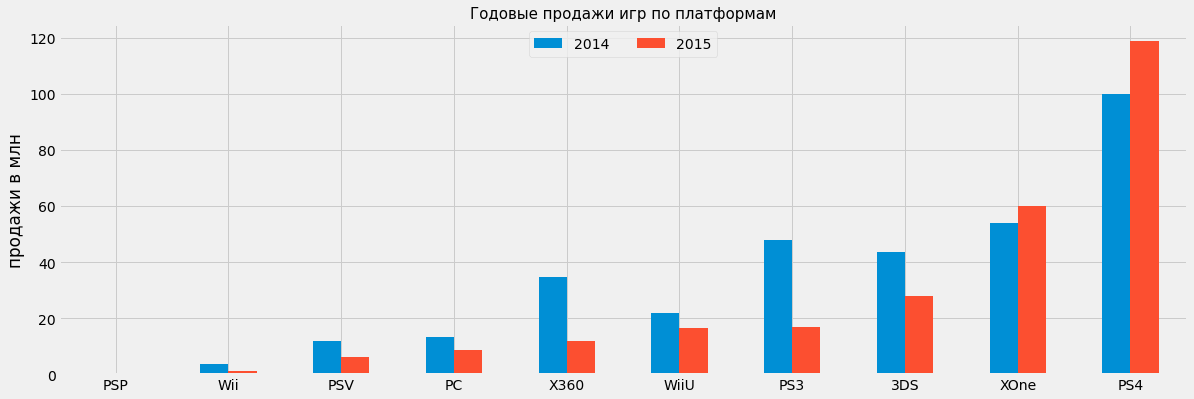

In [19]:
sales = actual_df.pivot_table(index='platform', columns='year_of_release', values='ww_sales', aggfunc='sum').fillna(0)
sales.sort_values(by=[2015, 2014]).plot(kind='bar', grid=True)
plt.title('Годовые продажи игр по платформам', fontsize=15)
plt.legend(loc = 'upper center', ncol=11)
plt.xlabel('')
plt.ylabel('продажи в млн')
plt.xticks(rotation=0)
plt.show()

На графике отчетливо видно падение практически у всех платформ, за исключением PS4, XOne. Эти платформы растут потому что пока на хайпе. В свою очередь, через пару лет и они так же повторят судьбу предшественников, уступая место следующим поколениям приставок.

Выведем продажи пятерки лидирующих платформ. Столбиковую диаграмму и диаграммы размаха

In [20]:
actual_top_n = 5
actual_top_platform_list = (
    actual_df.pivot_table(index='platform', values='ww_sales', aggfunc='sum').
    reset_index().sort_values(by = 'ww_sales', ascending = False).
    head(actual_top_n)['platform'].to_list()
)
actual_df.pivot_table(index='platform', values='ww_sales', aggfunc='sum').reset_index().sort_values(by = 'ww_sales', ascending = False).head(actual_top_n)

,platform,ww_sales
3,PS4,218.90
9,XOne,114.21
0,3DS,71.54
2,PS3,64.58
8,X360,46.70


Создадим числовую матрицу статистик по всем платформам

In [21]:
# Напишем функцию для вычисления 1 и 3 квартилей
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

In [22]:
actual_df.groupby(['platform']).agg({'ww_sales': ['min', q25, 'median', 'mean', q75, 'max', 'count', 'sum']}).sort_values(by=('ww_sales','sum'), ascending=False)

ww_sales                                         
              min  q25 median mean  q75   max count    sum
platform                                                  
PS4          0.01 0.09   0.29 1.03 0.97 14.63   212 218.90
XOne         0.01 0.11   0.32 0.81 0.91  7.39   141 114.21
3DS          0.01 0.04   0.09 0.43 0.26 11.68   166  71.54
PS3          0.01 0.04   0.12 0.36 0.40  5.27   181  64.58
X360         0.01 0.08   0.23 0.48 0.63  4.28    98  46.70
WiiU         0.01 0.06   0.19 0.65 0.61  7.09    59  38.38
PC           0.01 0.03   0.08 0.22 0.26  3.05    97  21.80
PSV          0.01 0.02   0.04 0.09 0.10  1.96   210  18.15
Wii          0.01 0.03   0.17 0.49 0.85  2.01    10   4.89
PSP          0.01 0.01   0.02 0.03 0.02  0.09    13   0.36

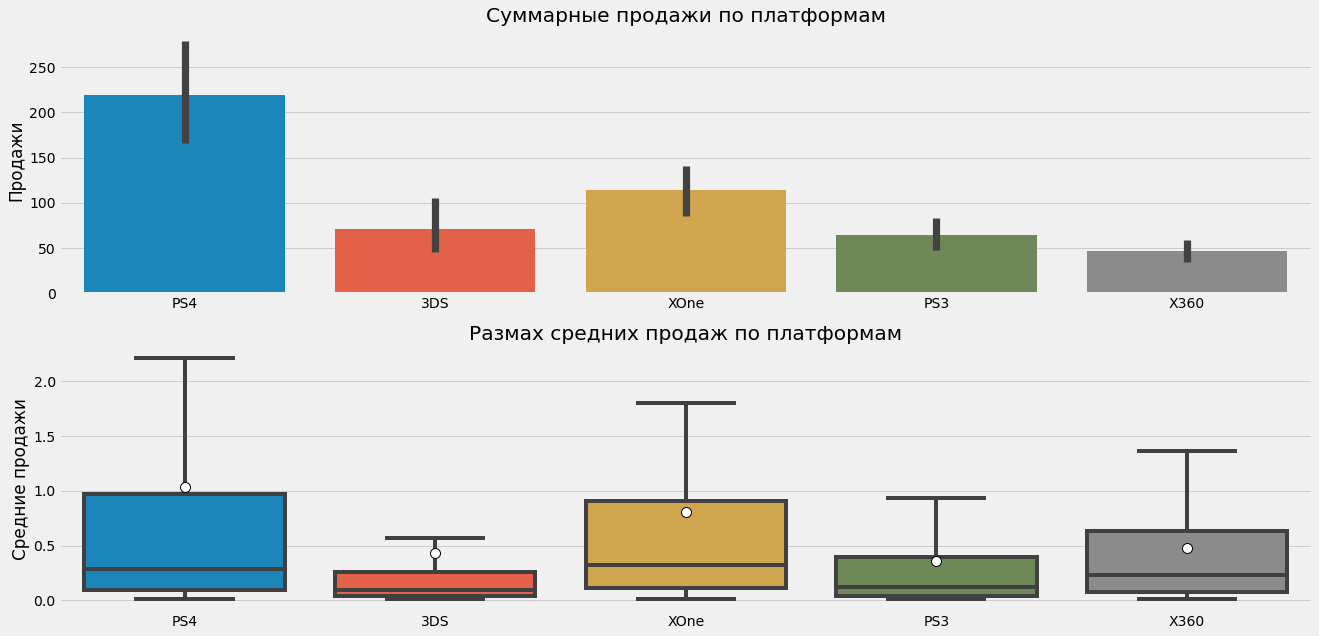

In [23]:
# Выведем на одном холсте два графика для сравнения: барплот и боксплот
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
sns.barplot(x = 'platform', y = 'ww_sales', data = actual_df.query('platform in @actual_top_platform_list'), estimator=sum, ax = axs[0]).set(title='Суммарные продажи по платформам', ylabel='Продажи', xlabel='')
sns.boxplot( x = 'platform', y = 'ww_sales', data = actual_df.query('platform in @actual_top_platform_list').sort_values(by='ww_sales', ascending=False), showfliers=False, showmeans=True, 
    meanprops={'marker':'o', 'markerfacecolor':'white', # Добавим белую точку - среднюю для оценки места положения
               'markeredgecolor':'black', # относительно медианы
               'markersize':'10'}, ax = axs[1]).set(title='Размах средних продаж по платформам', ylabel='Средние продажи', xlabel='')
plt.show()

В пятерке лидеров прослеживаются восходящие звезды PS4 и XOne, а недавно популярная PS3 в стадии заката. X360 и 3DS так же на спаде. Суженность усатых ящиков платформ 3DS и PS3 говорит о не особо больших продажах отдельных игр, свои высокие общие продажи они достигают за счет большого ассортимента. У PS4 довольно большой размах по продажам отдельных наименований, а из за того что таких наименований так же много эта платформа лидирует в общем объеме.  
У всех платформ средняя смещена к 3 квартилю и выше. Это значит что среди большинства заурядных игр до 1 млн копий встречаются сверх популярные тяжеловесы, сильно смещающие среднюю кверху.

#### 3.5. Влияние на продажи отзывов пользователей и критиков  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.5"></a>

Для анализа влияния отзывов пользователей и критиков построим корреляционные таблицы облаченные в тепловые карты и матрицы рассеяния по ТОП 5 платформ

Взаимосвязь отзывов и продаж для платоформы PS4


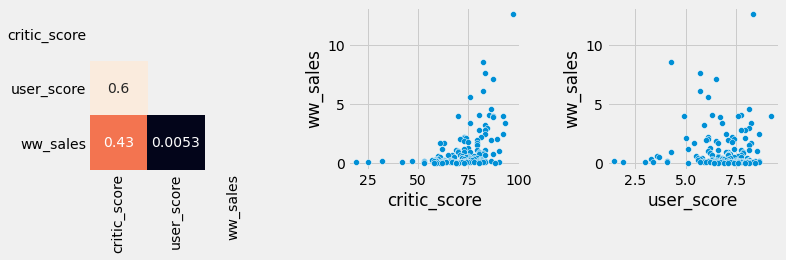

Взаимосвязь отзывов и продаж для платоформы XOne


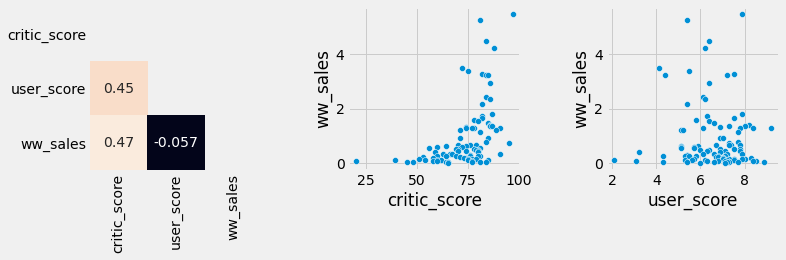

Взаимосвязь отзывов и продаж для платоформы 3DS


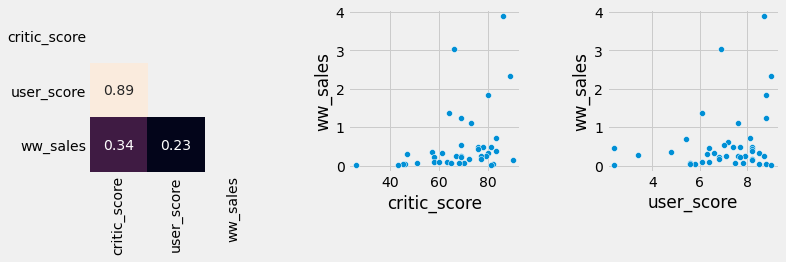

Взаимосвязь отзывов и продаж для платоформы PS3


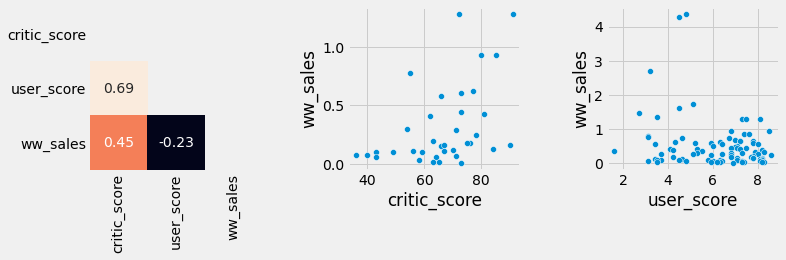

Взаимосвязь отзывов и продаж для платоформы X360


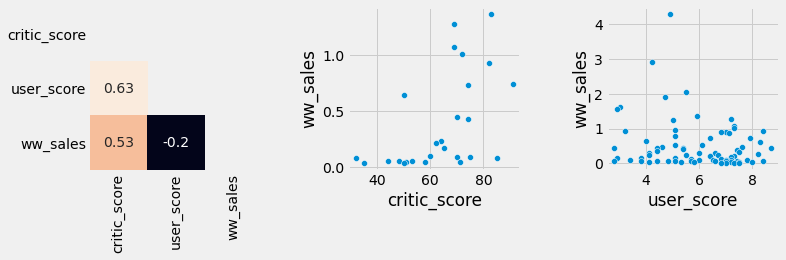

In [24]:
for plat_name in actual_top_platform_list:
    print(f'Взаимосвязь отзывов и продаж для платоформы {plat_name}')
    cols = ['critic_score', 'user_score', 'ww_sales']
    fig, axs = plt.subplots(1, 3, figsize=(11, 2.8))
    mask = np.triu(actual_df.query('platform == @plat_name')[cols].corr())
    sns.heatmap(actual_df.query('platform == @plat_name')[cols].corr(), annot=True, fmt='.2g', mask=mask, cbar=False, ax = axs[0])
    sns.scatterplot(x='critic_score', y='ww_sales', data=actual_df.query('platform == @plat_name'), ax = axs[1])
    sns.scatterplot(x='user_score', y='ww_sales', data=actual_df.query('platform == @plat_name'), ax = axs[2])
    plt.subplots_adjust(wspace=0.5, hspace=0.3)
    plt.show()

У всех платформ оценки пользователей совсем не влияют на продажи. Заметней влияние оценок критиков. У единственной 3DS оценки пользователей оказывают незначительное влияние на продажи, почти такое же как оценки критиков. Хочется отметить более сильную взаимосвязь между оценками критиков и пользователей. Скорее всего мнение одних основано на мнении других.

#### 3.6. Анализ распределения игр по жанрам  
[к оглавлению](#step_0)
<a class="anchor" id="step_3.6"></a>

Создадим числовую матрицу статистик по всем жанрам, а затем столбиковую диаграмму с объемами продаж и диаграммы размаха средних продаж

In [25]:
actual_df.groupby(['genre']).agg({'ww_sales': ['min', q25, 'median', 'mean', q75, 'max', 'count', 'sum']}).sort_values(by=('ww_sales','sum'), ascending=False)

ww_sales                                         
                  min  q25 median mean  q75   max count    sum
genre                                                         
Action           0.01 0.04   0.11 0.38 0.34 12.62   441 169.25
Shooter          0.02 0.31   0.68 1.64 1.72 14.63    81 132.72
Sports           0.01 0.08   0.36 0.76 0.77  8.58   113  85.99
Role-Playing     0.01 0.06   0.11 0.50 0.46 11.68   167  83.26
Misc             0.01 0.03   0.17 0.43 0.41  5.27    81  34.95
Racing           0.01 0.05   0.17 0.55 0.43  7.09    45  24.73
Fighting         0.01 0.07   0.13 0.54 0.32  7.55    44  23.75
Platform         0.01 0.05   0.25 0.65 1.16  3.21    23  14.86
Adventure        0.01 0.02   0.04 0.11 0.09  1.66   129  13.73
Simulation       0.01 0.04   0.16 0.43 0.36  3.05    26  11.24
Strategy         0.01 0.03   0.06 0.12 0.21  0.52    24   2.83
Puzzle           0.01 0.02   0.05 0.17 0.11  1.19    13   2.20

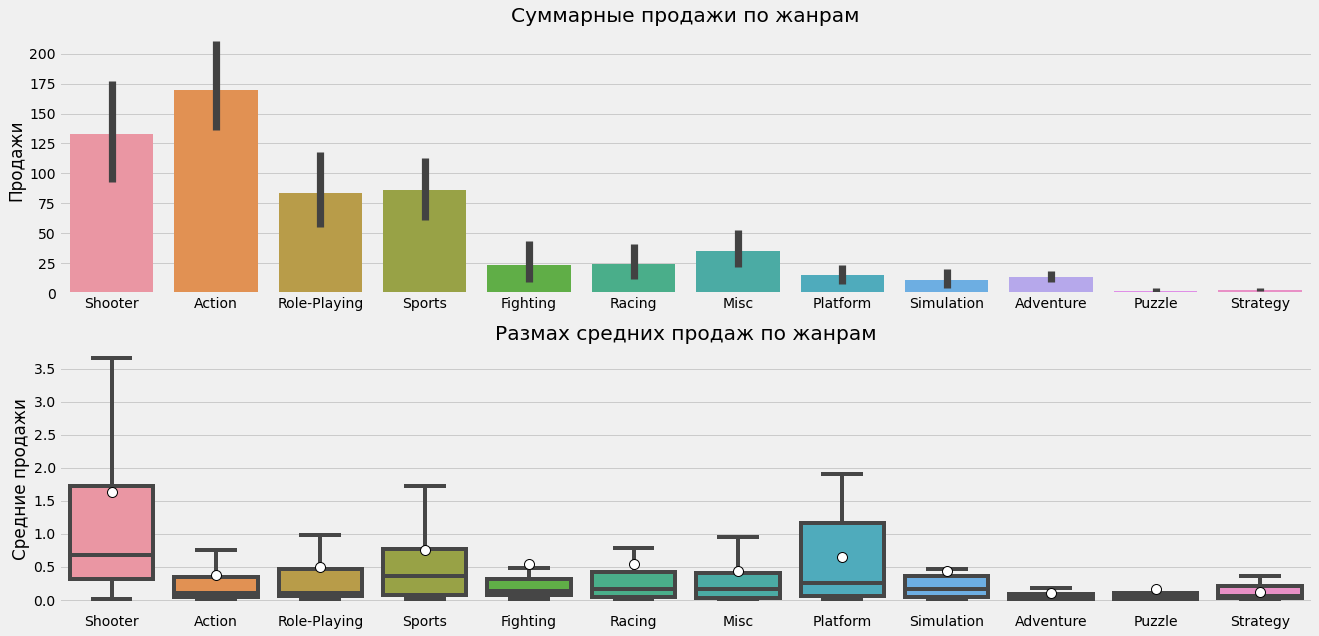

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
sns.barplot(x = 'genre', y = 'ww_sales', data = actual_df, estimator=sum, ax = axs[0]).set(title='Суммарные продажи по жанрам', ylabel='Продажи', xlabel='')
sns.boxplot( x = 'genre', y = 'ww_sales', data = actual_df.sort_values(by='ww_sales', ascending=False), showfliers=False, showmeans=True, 
    meanprops={'marker':'o', 'markerfacecolor':'white', 
               'markeredgecolor':'black',
               'markersize':'10'}, ax = axs[1]).set(title='Размах средних продаж по жанрам', ylabel='Средние продажи', xlabel='')
plt.show()

Столбиковая диагрмма говорит о лидерстве жанра Action, Shooter, Sports и Role-Playing. 
Диаграммы размаха демонстрируют узкий диапазон Action и Role-Playing, а так же большую вариативность у Shooters и Sports. Как и в случае с диаграммами по платформам высокие продажи у Actions достагаются большим ассортиментом однотипных продуктов а у Shooter и  Sports явными бестеллерами.

### 4. Портрет пользователя каждого региона.    
[к оглавлению](#step_0)
<a class="anchor" id="step_4"></a>


Определим для пользователя каждого региона (NA, EU, JP):  
- Самые популярные платформы (топ-5).
- Самые популярные жанры (топ-5).


In [27]:
# Создадим вспомогательный датафрейм из словаря с соответствиями русских названий техническим названиям столбцов рабочего датафрейма
regions_df = pd.DataFrame.from_dict({'na_sales': 'Америка', 'eu_sales': 'Европа', 'jp_sales': 'Япония'}, orient='index').reset_index()
regions = regions_df['index'].to_list()

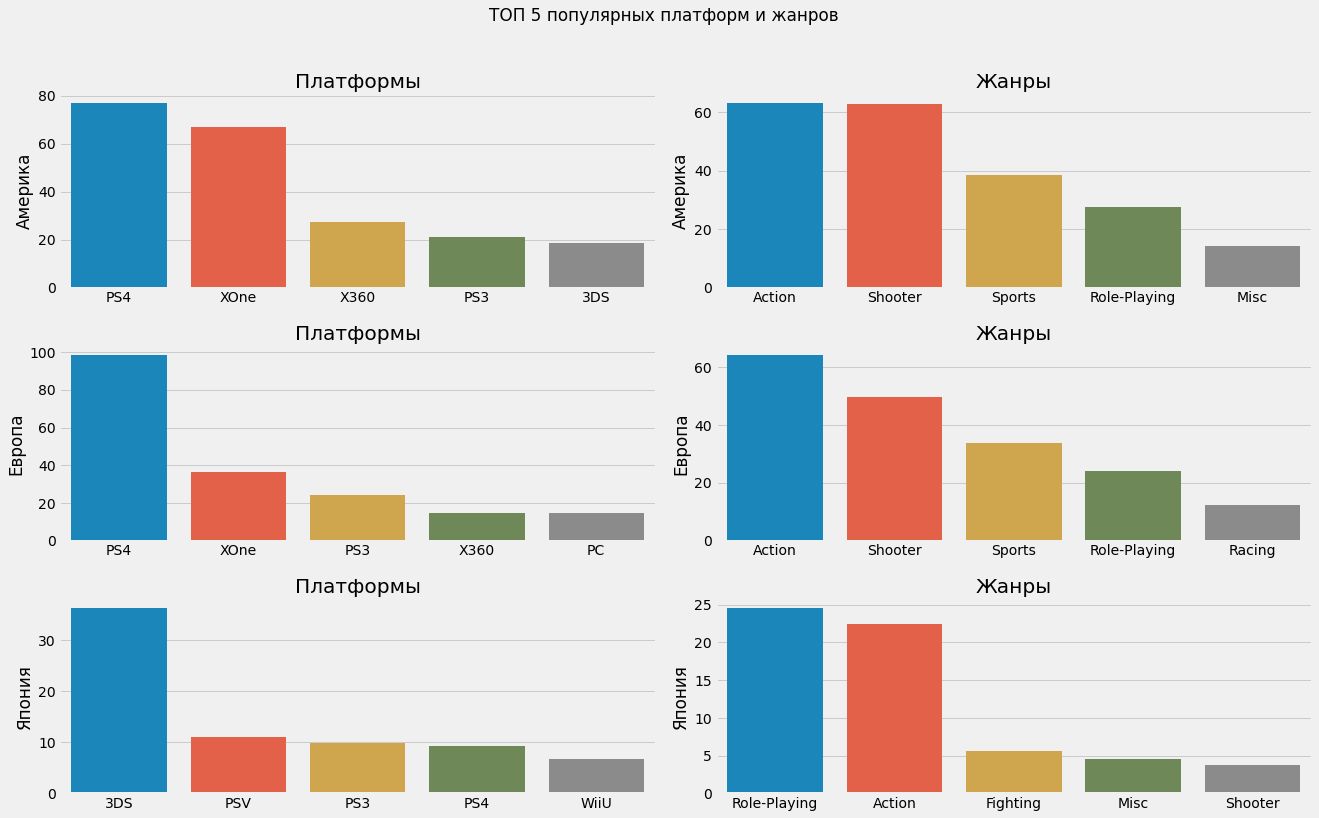

In [28]:
# В циклах создадим холст из 6 диаграмм 3 для платформ и регионов + 3 для жанров и регионов
fig, axs = plt.subplots(3, 2, figsize=(20, 12))
for i, key in enumerate(regions):
    data=actual_df.pivot_table(index='platform', values=[key], aggfunc='sum').reset_index().sort_values(by=key, ascending=False).head(5)
    sns.barplot(x='platform', y=key, data=data, ax = axs[i][0]).set(title='Платформы', ylabel=regions_df.loc[i,0], xlabel='')
for i, key in enumerate(regions):
    data=actual_df.pivot_table(index='genre', values=[key], aggfunc='sum').reset_index().sort_values(by=key, ascending=False).head(5)
    sns.barplot(x='genre', y=key, data=data, ax = axs[i][1]).set(title='Жанры', ylabel=regions_df.loc[i,0], xlabel='')
plt.suptitle('ТОП 5 популярных платформ и жанров')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

- Американцы любят PS4 и Action, на втором месте X360 и XOne и Shooters
- У европейцев предпочтения по жанрам и платформам схожи, но разрыв между PS4 и XOne посущественней.
- Японцы заметно отличаются. Платформа 3DS и жанр Role-Playing. От японцев иного ожидать и не стоило.

Выясним как влияет наличие рейтинга ESRB на продажи в трех регионах. Рассчитаем коэффициенты корреляций

In [29]:
# Создадим булев столбец деменстрирующий наличие или отсутствие рейтинга
actual_df['rating_exist'] = actual_df['rating'].notnull()
# Рассчитаем коэффициентры корреляций наличия рейтинга и продаж по регионам
actual_df[['na_sales', 'eu_sales', 'jp_sales', 'rating_exist']].corr().reset_index().query('index == "rating_exist"')

,index,na_sales,eu_sales,jp_sales,rating_exist
3,rating_exist,0.17,0.15,-0.07,1.00


В Америке и Европе влияние рейтинга очень незначительно и положительное, в Японии совсем отсутствует, даже слегка отрицательно. Продемонстрируем эти зависимости на графиках рассеивания.

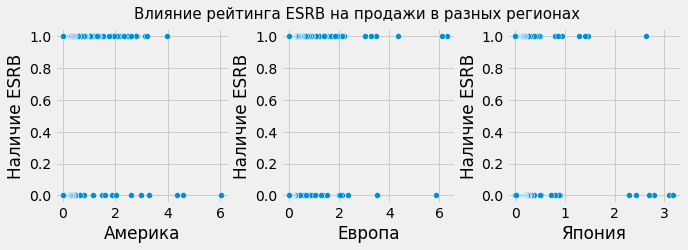

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for i, key in enumerate(regions):
    sns.scatterplot(x=key, y='rating_exist', data=actual_df, ax = axs[i]).set(ylabel='Наличие ESRB', xlabel=regions_df.loc[i,0])
plt.suptitle('Влияние рейтинга ESRB на продажи в разных регионах', fontsize=15)
plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()

Как видим Америки и Европы точки демонстрирующие продажи в районе единиц чуть плотнее чем в районе нулей. В японии эта связь практически отсутствует.

### Вывод
Пользователи из Америки и Европы скорее схожи по предпочтениям отностительно платформ жанров и наличию рейтинга ESRB. Чего нельзя сказать о японцах. Там любят увядающую 3DS, ролевые игры и вообще не обращают внимание на ESRB

### 5. Проверка гипотез.  
[к оглавлению](#step_0)
<a class="anchor" id="step_5"></a>

#### Выдвинем гипотезы:  

- H0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- H1 - Средние пользовательские рейтинги платформ Xbox One и PC различны.  
---------------------------------
- H0 - Средние пользовательские рейтинги жанров Action и Sports одинаковые.
- H1 - Средние пользовательские рейтинги жанров Action и Sports различны.

In [31]:
# Предварительно создадим мвссивы для удобства стат тестов
# Удалим все потенциательные значения NaN
xone_score = actual_df.query('platform == "XOne"')['user_score'].dropna()
pc_score = actual_df.query('platform == "PC"')['user_score'].dropna()
action_score = actual_df.query('genre == "Action"')['user_score'].dropna()
sports_score = actual_df.query('genre == "Sports"')['user_score'].dropna()
alpha = .05 # Зададим критический уровень альфа

Проведем T-тест на ревенство средних пользовательских рейтингов для платформ PC и XOne. 
Для этого построим графики плотности и проведем предварительные тесты на нормальность распределений и равенство дисперсий.  
Нормальность проверим тестом Шапиро-Уилка. В случае нормального распределения тестом Бартлетта проверим равенство дисперсий, в противном случае применим тест Левена.

##### Создадим функции подтверждающие или отклоняющие Нулевые гипотезы  
____________

In [32]:
# Фунция определения нормальности распределения на основе теста Шариро-Уилка
def norm_distribution(a):
    norm_distribution = True
    stat, p = st.shapiro(a)
    if p > alpha:       
        norm_distribution = True
    else:
        norm_distribution = False
    return norm_distribution # В результате распределение либо нормально, либо ненормально

In [33]:
# Функция определения равенства дисперсий
def equality_variance(a, b):
    equality_variance = True
    if norm_distribution(a) and norm_distribution(b): # Если два массива распределены нормально - определяем равенство тестом Бартлетта
        stat, p = st.bartlett(a, b)
        if p > alpha:
            equality_variance = True
        else:
            equality_variance = False
    else:
        stat, p = st.levene(a, b, center='mean') # Если хотябы один ненормально - тестом Левена
        if p > alpha:
            equality_variance = True
        else:
            equality_variance = False
    return equality_variance  # В результате дисперсии либо равны, либо нет

In [34]:
# Фунция принятия или отклонения H0
def ttest(a, b):
    print(f'Гипотеза о равенстве выборок {get_name(a)} и {get_name(b)}:')
    if equality_variance(a, b): # Если дисперсии равны equal_var=True
        results = st.ttest_ind(a, b, equal_var=True)
        print(f'p-значение: {(results.pvalue):.5%}')
        if results.pvalue < alpha:
            print('Отклоняем нулевую гипотезу')
        else:
            print('Недостаточно оснований отклонить нулевую гипотезу')
    else:
        results = st.ttest_ind(a, b, equal_var=False) # иначе equal_var=False
        print(f'p-значение: {(results.pvalue):.5%}')
        if results.pvalue < alpha:
            print('Отклоняем нулевую гипотезу')
        else:
            print('Недостаточно оснований отклонить нулевую гипотезу')

Выведем сравнение распределения плотностей рейтингов двух платформ

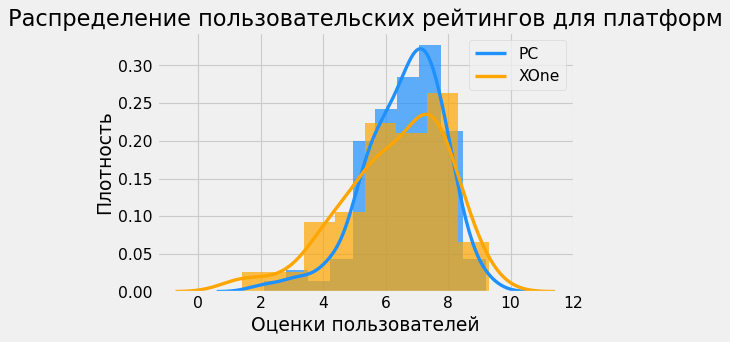

In [35]:
plt.figure(figsize=(6,4), dpi= 80)
ax = sns.distplot(xone_score, color="dodgerblue", label='', hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(pc_score, color="orange", label='', hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, ax = ax)
plt.title('Распределение пользовательских рейтингов для платформ')
plt.legend(['PC', 'XOne'])
plt.xlabel('Оценки пользователей')
plt.ylabel('Плотность')
plt.show()

In [36]:
ttest(xone_score, pc_score)

Гипотеза о равенстве выборок xone_score и pc_score:
p-значение: 20.64150%
Недостаточно оснований отклонить нулевую гипотезу


**Результаты теста говорят о том что вероятность случайно получить такие или большие различия средних пользовательских рейтингов в случае принятия нулевой гипотезы составляет почти 21%, следовательно эти выборки скорее всего равны**

Проведем аналогичные действия определения для равенства пользовательских рейтингов жанров Action и Sports 

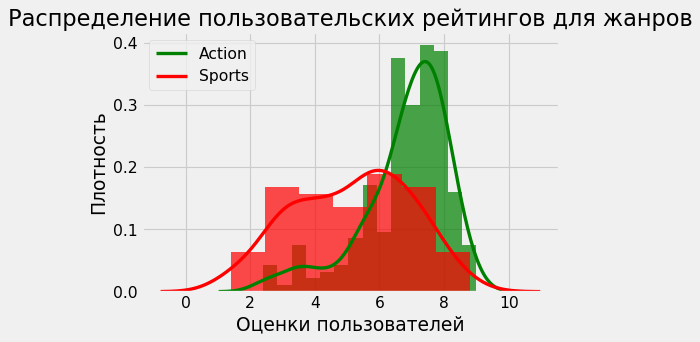

In [37]:
plt.figure(figsize=(6,4), dpi= 80)
ax = sns.distplot(action_score, color="g", label='', hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
sns.distplot(sports_score, color="r", label='', hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, ax = ax)
plt.title('Распределение пользовательских рейтингов для жанров')
plt.legend(['Action', 'Sports'])
plt.xlabel('Оценки пользователей')
plt.ylabel('Плотность')
plt.show()

In [38]:
ttest(action_score, sports_score)

Гипотеза о равенстве выборок action_score и sports_score:
p-значение: 0.00000%
Отклоняем нулевую гипотезу


_________________

**Результаты теста говорят о том что вероятность случайно получить такие или большие различия средних пользовательских рейтингов в случае принятия нулевой гипотезы приближается к нулю, следовательно эти выборки скорее всего различны.**

### 6. Общий вывод.  
[к оглавлению](#step_0)
<a class="anchor" id="step_6"></a>


Напоследок выведем ассортимент из 50 самых продаваемых игр на ТОП 5 платформах

In [39]:
stock = (actual_df.query('platform in @actual_top_platform_list').
 pivot_table(index=['platform', 'name'], values='ww_sales', aggfunc='sum').
 reset_index().sort_values(by='ww_sales', ascending=False).
 head(50)
)
stock['%'] = stock['ww_sales'] / stock['ww_sales'].sum()
stock.set_index(np.arange(len(stock)))


,platform,name,ww_sales,%
0,PS4,Call of Duty: Black Ops 3,14.63,0.06
1,PS4,Grand Theft Auto V,12.62,0.05
2,3DS,Pokemon Omega Ruby/Pokemon Alpha Sapphire,11.68,0.05
3,PS4,FIFA 16,8.58,0.04
4,PS4,Star Wars Battlefront (2015),7.98,0.03
5,PS4,Call of Duty: Advanced Warfare,7.66,0.03
6,3DS,Super Smash Bros. for Wii U and 3DS,7.55,0.03
7,XOne,Call of Duty: Black Ops 3,7.39,0.03
8,PS4,Fallout 4,7.17,0.03
9,PS4,FIFA 15,6.08,0.03


При планировании деятельности на 2017 год магазину стоит обратить внимание на активность платформ за последние три года. Для удержания позиций на американском и европейском рынках стоит закрепиться на платформах PS4 и XOne. На японский рынок делать серьезные ставки не стоит. Также стоит обратить внимание на PC, мал золотник, да дорог - свою копейку точно принесет. В любом случае нужно следить за новинками, которые в последнее время если появляются то привлекают большой интерес пользователей. В плане жанров сделать ставку на Action, Shooter и Sports. На рейтинги пользователей обращать внимание смысла большого нет, а к мнению критиков прислушиваться все таки стоит. **Склад сформировать из предложенного списка в предложенных процентах, остальные экземпляры, для любителей экзотики - под заказ**

конец